In [1]:
import copy
import networkx as nx
import matplotlib.pyplot as plt

# Global Variable variables
neighbours = {}
start_variables = {}

# Function to read data from the input file
def fileReader(textfile):
    neighbours.clear()
    start_variables.clear()
    with open(textfile, "r") as f:
        data = f.readlines()
    # Process each line of data
        for line in data:
            if line.startswith('#') or line.strip() == "":
                continue
            elif line.startswith('c'):
                colors = int(''.join(filter(str.isdigit, line)))
                continue
            # Split the line into two nodes
            node1, node2 = map(int, line.strip().split(","))
            # Update the neighbours
            if node1 not in neighbours:
                neighbours[node1] = []
            neighbours[node1].append(node2)
            if node2 not in neighbours:
                neighbours[node2] = []
            neighbours[node2].append(node1)
            # Update the variables
            if node1 not in start_variables:
                start_variables[node1] = [None, list(range(1, colors+1))]
            if node2 not in start_variables:
                start_variables[node2] = [None, list(range(1, colors+1))]
#####################################################################################################

# Class definition of a state
class color:
    
    # Constructor to intialize the fields of the current state
    def __init__(self, assigned, variables):
        self.assigned = assigned   # Stores the variables that already have been assigned
        self.variables = variables # Stores the current state of the graph
        self.curr = None           # Stores the current variable chosen to assign from the MRV Heuristic
    
    # Function to print the variables with their values
    def printvar(self):
        for var in self.variables:
            print(var,"has color", self.variables[var][0])
            
    # Function to visualise the final coloured graph
    def colorGraph(self):
        G = nx.Graph()
        for node, neighbours_list in neighbours.items():
            G.add_node(node)
            for neighbour in neighbours_list:
                G.add_edge(node, neighbour)
        # Draw the graph
        pos = nx.spring_layout(G)
        # Define a color map
        colors_map = {1: 'red', 2: 'green', 3: 'blue', 4: 'yellow', 6: 'pink', 7: ' brown'}
        # Loop over the nodes and their assigned colors
        for node, (color, _) in self.variables.items():
            if color is not None:
                nx.set_node_attributes(G, {node: colors_map[color]}, 'color')
        # Draw the graph with node colors
        node_colors = nx.get_node_attributes(G, 'color')
        nx.draw(G, pos, with_labels=True, node_color=list(node_colors.values()))
        plt.show()
        
#######################################################################################################        
# Find the intersection of element between 2 lists
def intersection(list1,list2):
    l1_set = set(list1)
    l2_set = set(list2)
    # check length
    if len(l1_set.intersection(l2_set)) > 0:
        return(list(l1_set.intersection(l2_set)))
    else:
        return []

# Function to ensure arc consistency
def arc_consistency(variables):
    
    # Generate all possible arcs and store them in a queue
    arcs = []
    keys = list(neighbours.keys())
    for var1 in keys:
        for var2 in neighbours[var1]:
            temp = []
            temp.append(var1)
            temp.append(var2)
            arcs.append(temp)
    
    while len(arcs) > 0:
        curr_arc = arcs.pop(0)
        
        result = remove_inconsistent_values(curr_arc, variables)
        if result is not None:
            if result:
                for neighbour in neighbours[curr_arc[0]]:
                    for var2 in neighbours[neighbour]:
                        temp = []
                        temp.append(neighbour)
                        temp.append(var2)
                        if temp not in arcs:
                            arcs.append(temp)
        else:
            print("Exiting Recursion")
            return None
    
    return variables

# Function to remove the inconsistent values in an arc.
def remove_inconsistent_values(arc,variables):
    removed = False
    
    for val1 in variables[arc[0]][1]:
        consistent = False
        for val2 in variables[arc[1]][1]:
            if(val1 != val2):
                consistent = True
                break
        # If val1 is not consistent for any value in the neighbours domain
        if not consistent:
            variables[arc[0]][1].remove(val1)
            removed = True
        # If the domain of any variable becomes empty
        if len(variables[arc[0]][1]) == 0:
            print("Domain Inconsistent")
            return None 
    return removed

# Function to find the minimum remaining variable to be assigned
def minimum_remaining_variable(state):
    not_assigned = {}
    # Find all unnassigned variables in the graph
    temp = [key for key in state.variables if state.variables[key][0] == None]
    # Makes a dictionary with the unnassigned neighbours and their respective domain values
    for var in temp:
        if var in state.variables:
            not_assigned[var] = state.variables[var][1]
    
    # Sort the neighbours based on their domain lengths
    sorted_items = sorted(not_assigned.items(), key=lambda x: len(x[1]))
    
    return sorted_items[0][0] # return first key in the first record of key value pair

# Function to find the least constraining value
def least_constraining_value(state):
    not_assigned = {}
    # Find all unnassigned variables in the graph
    temp = [element for element in neighbours[state.curr] if element not in state.assigned]

    # Makes a dictionary with the unnassigned neighbours and their respective domain values
    for var in temp:
        if var in state.variables:
            not_assigned[var] = state.variables[var][1]
    
    # Find all the assigned variables
    assigned_neighbours = intersection(neighbours[state.curr],state.assigned)
    
    # Calculate list of consistent from the domain of the current variable
    possible_values = []
    for domain_val in state.variables[state.curr][1]:
        isAssign = True
        for assigned_var in assigned_neighbours:
            if domain_val == state.variables[assigned_var][0]:
                isAssign = False
                
        if isAssign:
            possible_values.append(domain_val)
    
    # Find the no of constraints of each consistent domain value
    val_with_count = {}
    for val in possible_values:
        count = 0
        for neighbour_domain in not_assigned.values():
            # Count occurences of current value in the domains of its neighbours
            count += neighbour_domain.count(val)
        val_with_count[val] = count
    
    # Sort in ascending order based on the no of constraints and return the list
    sorted_vals = sorted(val_with_count, key=lambda k: val_with_count[k])
    return sorted_vals

# Function to call the backtracking search
def backtrack(filename):
    fileReader(filename)
    curr_state = color([],copy.deepcopy(start_variables))
    result = backtrack_search(curr_state)
    
    if result == "Empty" or result == None:
        print("No Solution Exists")
       
    else:    
        result.printvar() # Print the variables in the graph
        result.colorGraph() # Print the visualization of the completed graph

# Recursive function that performs backtracking search based on the heuristics
def backtrack_search(state):
    # If all the variables have been assigned
    if len(state.assigned) == len(state.variables):
        return state
    # Assign the current variable
    state.curr = minimum_remaining_variable(state)
    
    # Iterate through the possible values and backtrack if necessary
    for val in least_constraining_value(state):
        
        # Updating the new value
        new_variables = copy.deepcopy(state.variables)
        updated_assigned = copy.deepcopy(state.assigned)
        new_variables[state.curr][0] = val
        new_variables[state.curr][1] = [x for x in new_variables[state.curr][1] if x == val]
        updated_assigned.append(state.curr)
        
        # Performing constraint propagation on the new assignment
        AC3 = arc_consistency(new_variables)
        if AC3 is not None:
            result = backtrack_search(color(updated_assigned, new_variables))
            
            # "Empty" denotes failure. It is returned when any variable has an empty domain from AC3
            if result == "Empty":
                return "Empty"
            # If a result that satisfies constraints has been found
            if result is not None:
                return result
        else: 
            return "Empty"
    
    # If all values have been tried and a solution was not reached. Bactrack and try another value
    return None
        

In [4]:
def test_input1():
    backtrack('input1.txt')

def test_input2():
    backtrack('input2.txt')

def test_input3():
    backtrack('input3.txt')
    
def test_input4():
    backtrack('input4.txt')
    
def test_input5():
    backtrack('input5.txt')

1 has color 1
2 has color 2
3 has color 3
4 has color 3
5 has color 2
6 has color 1
7 has color 4


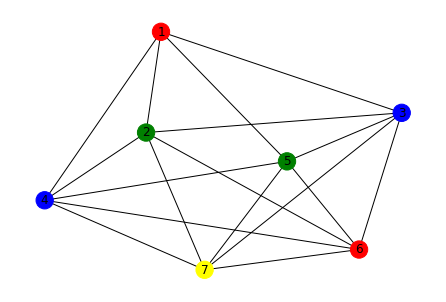

0 has color 1
1 has color 2
2 has color 2
3 has color 2
4 has color 2
5 has color 1
6 has color 1
7 has color 1
8 has color 1
9 has color 2
10 has color 1
11 has color 2
12 has color 2
13 has color 2
14 has color 2
15 has color 1
16 has color 1
17 has color 1
18 has color 2
19 has color 3
20 has color 3
21 has color 1
22 has color 2
23 has color 2
24 has color 3
25 has color 1
26 has color 1
27 has color 3
28 has color 1
29 has color 2
30 has color 2
31 has color 3
32 has color 2
33 has color 1
34 has color 3
35 has color 3
36 has color 2
37 has color 1
38 has color 3
39 has color 1
40 has color 3
41 has color 1
42 has color 3
43 has color 1
44 has color 2
45 has color 1
46 has color 3
47 has color 1
48 has color 2
49 has color 1
50 has color 2
51 has color 3
52 has color 2
53 has color 1
54 has color 2
55 has color 3
56 has color 3
57 has color 1
58 has color 3
59 has color 1


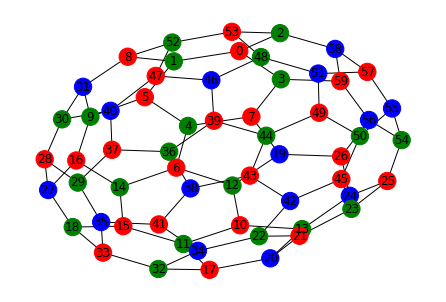

0 has color 1
1 has color 2
2 has color 3
3 has color 2
4 has color 3
5 has color 2
6 has color 3
7 has color 3
8 has color 1
9 has color 1
10 has color 4
11 has color 1
12 has color 2
13 has color 4
14 has color 3
15 has color 1
16 has color 4
17 has color 2
18 has color 4
19 has color 3
20 has color 1
21 has color 2
22 has color 4


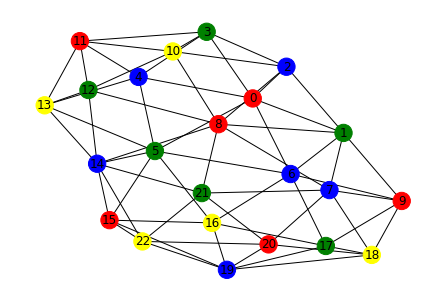

Domain Inconsistent
Exiting Recursion
No Solution Exists
0 has color 1
1 has color 2
2 has color 2
3 has color 3
4 has color 3
5 has color 4
6 has color 4
7 has color 1
8 has color 2
9 has color 2
10 has color 3
11 has color 4
12 has color 3
13 has color 2
14 has color 1
15 has color 3
16 has color 4


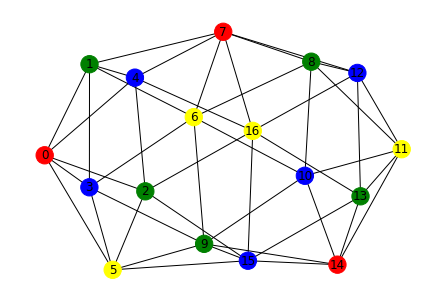

All inputs processed respective solutions found


In [5]:
if __name__ == "__main__":
    test_input1()
    test_input2()
    test_input3()
    test_input4()
    test_input5()
    print("All inputs processed respective solutions found")

0 has color 1
1 has color 2
2 has color 2
3 has color 2
4 has color 2
5 has color 1
6 has color 1
7 has color 1
8 has color 1
9 has color 2
10 has color 1
11 has color 2
12 has color 2
13 has color 2
14 has color 2
15 has color 1
16 has color 1
17 has color 1
18 has color 2
19 has color 3
20 has color 3
21 has color 1
22 has color 2
23 has color 2
24 has color 3
25 has color 1
26 has color 1
27 has color 3
28 has color 1
29 has color 2
30 has color 2
31 has color 3
32 has color 2
33 has color 1
34 has color 3
35 has color 3
36 has color 2
37 has color 1
38 has color 3
39 has color 1
40 has color 3
41 has color 1
42 has color 3
43 has color 1
44 has color 2
45 has color 1
46 has color 3
47 has color 1
48 has color 2
49 has color 1
50 has color 2
51 has color 3
52 has color 2
53 has color 1
54 has color 2
55 has color 3
56 has color 3
57 has color 1
58 has color 3
59 has color 1


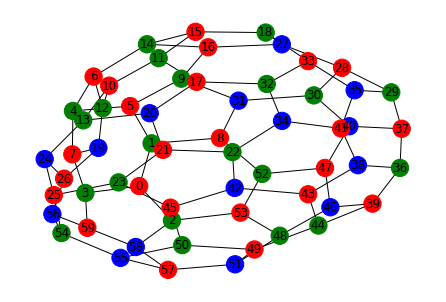

In [6]:
backtrack("test.txt")